# Mixture Density Networks in GPflow

## Introduction
This notebook implements Mixture Density Networks (Bishop, 1994 see [2]) in gpflow, extending implementation for one-dimensional targets published by 
Vincent Dutordoir [1]. Bayesian-based model selection (penalizing network complexity) is also illustrated.

Mixture Density Networks are models for conditional density estimation. 
In the most popular setup they consist of a <em>mixture of gaussians</em>, and a neural net which predicts characteristics of the gaussian components (mean and variance) along with mixture coefficients. 

The conditional density of the target $Y\in\mathbb{R}^c$ given input $X\in\mathbb{R}^d$ is modeled as

$$
\begin{align*}
p(Y=y|X=x) \sim \sum_{i=1}^{m}\alpha_i(x)\cdot \frac{1}{(2\pi)^{\frac{c}{2}} \sigma_i(x)^c}\exp\left(-\frac{\|y-\mu_i(x)\|^2}{2\sigma_i(x) ^2}\right) 
\end{align*}
$$

where $m$ is the number of mixtures, $\{\alpha_i(\cdot)\}_{i=1}^{m}$ are non-negative weights (dependent on input $x$),
such that $\sum_{i=1}^{m}\alpha_i(x)=1$, means $\{\mu_i(\cdot)\}_{i=1}^{m}$ are $c$-dimensional vectors (dependent on inut $x$), $\{\sigma_i(\cdot)\}_{i=1}^{m}$ are non-negative standard-deviations (dependent on input $x$, one for each mixture!) and the norm notation is understood as $\|y-\mu_i(x)\|^2 = \sum_{i=1}^{c}(\mu_i(x)^{j}-y^{j})^2$ where $v^{j}$ is the $j$-th componet of the vector $v$.


## Remarks

<ul>
    <li><em>Approximation with shared diagonal variance</em>
Carefull readers realize that guassian kernels $y\rightarrow \exp\left(-\frac{\|y-\mu\|^2}{2\sigma^2}\right) $ assume a diagonal covariance with a diagonal value shared by all $c$ compoments. While this looks restrictive, with large number of such components one can approximate arbitrary density functions. For example, it's easy to see that we can perfectly match given probabilities at input points (interpolate). Supppose that $Y$ takes $n$ values $y_1,\ldots,y_n$ and that $x$ is fixed.
By taking $m=n$ mixtures with locations $\mu_i(x) = y_i$ and fixed variance $\sigma_i(x)=\sigma$ we obtain a system of $n$ equations with a positive definite matrix $A_{i,j} \propto \exp(-\frac{ \|y_j-y_i\|^2 }{2\sigma^2} )$, which can be solved for unknown $\alpha_i$. Making mixing weigths, means and variances dependent on inputs we gain even more flexibility and bringing <em>locality</em> to the model.
    </li>
    <li><em>Complexity and model selection</em> To produce all necessary paramters, the network output layer uses $m\cdot(c+2)$ neurons. Neurons in previous layers also contribute to the complexity. The likelihood as defined above assumes the network architecture is fixed, however it is possible to extend it so that it captures (and technically - penalizes!) model complexity - in the Bayesian regime they can be implemented as prior probabilities over admissible parameters and models. The simplest solution is to use Bayesian Information Criterion (for a rigorous derivation see [3])
       , one can also introduce customomized penalties [4]. This note shows how BIC can be used to disciriminate too complex models and prevent overfitting.
    </li>
    <li><em>Model convergence</em> Ensuring converge to the global optimum can be little tricky. The example discussed belows uses AdamOptimizer as it performed much better than ScipyOptimizer. Interestingly, the convergence can be tested analytically by means of KKT conditions, uder the (mild) assumption that the network architecture is reach and flexible enough to model all combinations of output components [2]. These techniques are not discussed here.
    </li>
</ul>

## Implementation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf

import gpflow as gp
from gpflow.decors import params_as_tensors, autoflow


class MDN(gp.models.Model):
    ''' implemmentation of Mixture Density Network (Bishop 1994)'''
    
    def __init__(self,X,Y,inner_dim=(10,10),n_mix = 3):
        ''' X = input, Y = target. Both are 2-dimensional of shape (n_samples,?) storing sample x feature '''
        
        assert X.shape[0] == Y.shape[0]
        
        gp.models.Model.__init__(self)
        
        # for every mixture we need one mix weight, one sigma, and mu for every target component 
        self.n_mix = n_mix
        self.target_dim = Y.shape
        self.input_dim = X.shape
        self.inner_dim = inner_dim
        self.dims = (self.input_dim[1],)+self.inner_dim+(self.n_mix*(2+self.target_dim[1]),)
        self.activation = tf.nn.tanh
        self.X = gp.params.DataHolder(X)
        self.Y = gp.params.DataHolder(Y)
        # create and initialize params for the network
        self._build_network()
        
    def _build_network(self):
        # network creates params mu, sigma for mixtures + mixing weights. 
        W,b = [],[]
        for dim_in,dim_out in zip(self.dims[:-1],self.dims[1:]):
            xavier_std = (2.0 / (dim_in + dim_out)) ** 0.5
            W.append(gp.params.Parameter(xavier_std*np.random.rand(dim_in,dim_out)))
            b.append(np.zeros(dim_out))
        self.W,self.b = gp.params.ParamList(W),gp.params.ParamList(b)
    
    @params_as_tensors
    def _eval_network(self,X):
        ''' evaluates the network, the decorator adds every gp.params.Parameter as a tf tensor'''
        # loop over layers; note that weights W and intercepts b will be captured as tf tensors
        for i,(W,b) in enumerate(zip(self.W,self.b)):
            # apply a linear transform
            X = tf.matmul(X,W)+b
            # apply activation, except at the outer layer
            if i<len(self.b)-1:
                X = self.activation(X)
        # unpack X into model params, align to be compatible with the shape (n_sample,n_target_out,n_mix) !
        mix = tf.expand_dims(X[:,:self.n_mix], axis=1)
        sigma = tf.expand_dims(X[:,self.n_mix:2*self.n_mix], axis=1)
        mu = tf.reshape(X[:,2*self.n_mix:], shape=(-1,self.target_dim[1],self.n_mix))
        # apply transforms to be within natural constraints (mixes are probabilities, variances are positive...)
        mix = tf.nn.softmax(mix,axis=-1)
        sigma = tf.exp(sigma)
        # output params
        return mix,mu,sigma
            
    @params_as_tensors
    def _eval_loglikelihood(self,X,Y):
        ''' evaluates the trained likelihood for each sample, given inputs and targets '''
        # unpack output into mix,mu,sigma params
        mix,mu,sigma = self._eval_network(X)
        # compute log-contributions to the likelihood for every (sample,target_out,mixture)
        Z = ( (2*np.pi)**0.5 ) * sigma
        log_like = -0.5*(tf.expand_dims(Y,axis=2)-mu)**2 / sigma**2 - tf.log(Z) + tf.log(mix)
        # reduce over target components - result in shape (sample,mixture)
        log_like = tf.reduce_sum(log_like,axis=1)
        # recude over mixtures
        log_like = tf.reduce_logsumexp(log_like,axis=1)
        # keep samples - don't reduce
        return log_like 

    @params_as_tensors
    def _build_likelihood(self):
        ''' evaluates the trained likelihood on the train data of all samples '''
        return tf.reduce_sum(self._eval_loglikelihood(self.X,self.Y))
        
    @autoflow((gp.settings.float_type, ))
    def eval_network(self, X):
        ''' evaluates the network and returns numpy output (decorator) '''
        mix, mu, sigma = self._eval_network(X)
        return mix, mu, sigma
        
    @autoflow((gp.settings.float_type, ), (gp.settings.float_type, ))
    def eval_loglikelihood(self, X,Y):
        ''' evaluates the likelihood on given input and target, returns numpy output '''
        return self._eval_loglikelihood(X,Y)    

## Example 

The discussion below shows how the MDN model can be used for anomaly detection.
The goal will be to identify crossaint crumbs.

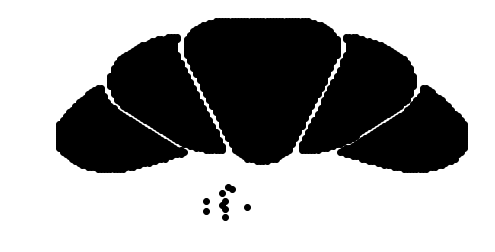

6316 data points


In [3]:
import imageio
import scipy

## load pic

pic =  imageio.imread(r'crossaint2.png')
pic = pic[:,:,3]

## add some noise
tmp = (115,50)+(np.array([5,5])*np.random.normal(size=(10,2))).round().astype(int)
tmp = np.clip(tmp,0,127)
mask = scipy.sparse.coo_matrix((np.ones(shape=tmp.shape[0]).astype(np.bool), (tmp[:,0],tmp[:,1])), shape=(128,128) )
pic = pic>0
pic[ mask.toarray() ] = 1

## prepare dataset

# need data in coo format, keep in mind that axes on images and plots are oriented in a different way
X = scipy.sparse.coo_matrix(pic)
X = np.vstack([X.col,127-X.row]).T.astype(np.float64)
X = (X-X.mean(0))/X.std()
#np.savetxt('croissant_mess.txt',X)

from matplotlib import pyplot as plt

X = np.loadtxt(r'croissant_mess.txt')

## visualize
fig,ax2 = plt.subplots(1,1,figsize=(8,4))
ax2.axis('off')
ax2.scatter(X[:,0],X[:,1],color='black')

plt.show()

print('%s data points'%pic.sum() )

We will use a simple MDM model with one intermadiate layer of $\ell=12$ neurons and $m=3$ mixtures.

In [4]:
## train the model

np.random.seed(42)

gp.reset_default_graph_and_session()
model = MDN(X,X,inner_dim=(12,),n_mix=2)
opt = gp.training.AdamOptimizer()
opt.minimize(model)

print('Maximal Log-Likelihood %s'%model.eval_loglikelihood(X,X).sum())
print('Trainable params %s'%np.sum([np.prod(v.shape.as_list()) for v in tf.trainable_variables()]))

Maximal Log-Likelihood 48676.38936349112
Trainable params 140


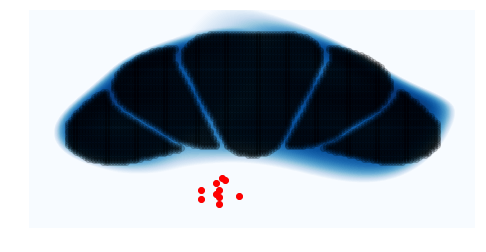

In [5]:
## visualize 

def visualize(X):

    # prepare the grid
    n_points = 100
    xx = np.linspace(X[:,0].min()-0.5,X[:,0].max()+0.5,n_points)
    yy = np.linspace(X[:,1].min()-0.5,X[:,1].max()+0.5,n_points)
    plot_x,plot_y = np.meshgrid(xx,yy)

    mix,mu,sigma = model.eval_network( np.vstack([plot_x.ravel(),plot_y.ravel()]).T )
    grid = np.vstack( [plot_x.ravel(),plot_y.ravel()] ).T 
    odds = model.eval_loglikelihood( grid,grid ).reshape(n_points,n_points)

    plt.figure(figsize=(8,4))

    plt.contourf(plot_x,plot_y,odds,500, cmap=plt.cm.Blues, vmin=-5)
    plt.scatter(X[:,0],X[:,1], alpha=0.2, color='black')#,'black', alpha=0.5, ms=3, label="data")

    # mark points with lowest likelihoods - anomalies
    odds=model.eval_loglikelihood(X,X)
    idx = odds.argsort()[:10]
    plt.scatter(X[idx][:,0],X[idx][:,1],color='red')

    plt.axis('off')
    plt.show()
    
visualize(X)

## Penalizing complexity 

Training the model as above we found the parameter values $\theta=\theta^{*}$ that maximize the data likelihood $L(\theta) = p(D\ |\ \theta)$. 
Under reasonable assumption, one can approximate the marginal likelihood, the data likelihood averaged over choices of parameters [3]

$$
\int p(D\ |\ \theta) p(\theta)\ \mbox{d}\theta \approx  p(D\ |\ \theta^{*}) \cdot \exp\left(-\frac{|\theta|}{2}\log n\right)
$$

where $n$ is the number of data points in $D$.

This is essentially the BIC formula, where
the number of parameters $|\theta|$ penalizes the fit measured by the maximum likelihood $L^{*} = L(\theta^{*})$. Takinng the logarithm we can write the measure of the overal fit as

$$
p(D) \approx \log L^{*} - \frac{|\theta|}{2}\log n
$$

To further account for different models we can can further factor by model $M$ and put priors on it. By Bayes rule for any model $M$ we have

$$
p(M\ |\ D) \propto p(D\ |\ M)\cdot p(M) = \int p(D\ |\ \theta_M)p(\theta_M)\ \mbox{d} \theta_M \cdot p(M)
$$

However the contribution from $p(M)$ is usually of smaller order than the term $\exp\left(-\frac{|\theta|}{2}\log n\right)$, unless in small-sample regimes (see [4]). 

To see how this helps avoiding overfiting, consider increasing the intermediate layers to $\ell=15$ neurons and using $m=3$ mixtures.

Maximal Log-Likelihood 48955.89930825775
Trainable params 222


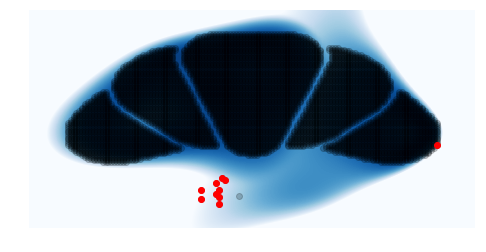

In [6]:
np.random.seed(42)
gp.reset_default_graph_and_session()

model = MDN(X,X,inner_dim=(14,),n_mix=3)
opt = gp.training.AdamOptimizer()
opt.minimize(model)

print('Maximal Log-Likelihood %s'%model.eval_loglikelihood(X,X).sum())
print('Trainable params %s'%np.sum([np.prod(v.shape.as_list()) for v in tf.trainable_variables()]))

visualize(X)

Although the likelihood improved by 500, by taking into account penalty terms we get worse fit (confirmed by visual inspection).

| Model &emsp; &emsp; &emsp; &emsp; | Maximal Log-Likelihood | Params   | Params Penalty (BIC) | Marginal Log-Likelihood (BIC)|
| --------------------- |------|------| --- | --- |
| $\ell=12,m=2$ | 48676 | 140 | 613  | 48063 |
| $\ell=14,m=3$ | 48956 | 222 | 971  | <b>47985</b> |

We conclude that either the second model overfits, or the optimization result is suboptimal.

## References 

[1] https://github.com/vdutor/MDNs-in-GPflow/blob/master/GPflow%20implementation%20of%20MDNs.ipynb)

[2] https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf

[3] http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.723.8015&rep=rep1&type=pdf

[4] https://www.eurasip.org/Proceedings/Eusipco/1996/paper/nn_5.pdf